# Burn severity mapping from DEA

This script shows the work flow of severity mapping using datacube data, including the calculation of geometric medians, cosine distance, NBR, severity mapping

## loading data from DEA
import the 'loaddea' module that extracts Landsat data from datacube and masked out cloudy pixels

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from loaddea import loaddea

Loading data from the datacube uses the loaddea function. Only the observation with more than 20% clear coverage in the selected region is accepted. 

The function takes several arguments:
    
    x; Defines the spatial region in the x dimension
    y; Defines the spatial region in the y dimension
    time; Defines the temporal extent
    resolution; Defines the spatial resolution
    landsat_numbers; Defines the numbers of Landsat in the list format, e.g. [5,7,8] or [8]

The default projected coordinate system: EPSG:3577 (GDA94 / Australian Albers)
The default product loaded is the 'Landsat*_nbart_albers'


We'll load the Landsat 8, for the spatial region covering:

    146.0852 -> 146.3702 degrees longitude
    -41.5985 -> -41.7314 degrees latitude

and a temporal extent covering:

    2013-01-01 -> 2017-12-31



In [2]:
# load the data for the selected region and period use the loaddea module, quality pixel mask has been applied
# return data with 6 bands and one pixel-mask used for the cloud masking
data = loaddea(x=(144.6893,145.1582),y=(-41.0711,-41.3711),time=('2013-01-01','2017-12-31'),resolution=(-100,100),landsat_numbers=[8]) 

In [3]:
data

<xarray.Dataset>
Dimensions:  (time: 43, x: 434, y: 366)
Coordinates:
  * time     (time) datetime64[ns] 2013-04-17T00:06:04 2013-06-20T00:06:10 ...
  * y        (y) float64 -4.545e+06 -4.545e+06 -4.545e+06 -4.545e+06 ...
  * x        (x) float64 1.084e+06 1.084e+06 1.084e+06 1.084e+06 1.084e+06 ...
Data variables:
    blue     (time, y, x) float64 nan nan 654.0 621.0 600.0 591.0 587.0 ...
    green    (time, y, x) float64 nan nan 613.0 601.0 567.0 565.0 556.0 ...
    red      (time, y, x) float64 nan nan 498.0 481.0 446.0 431.0 412.0 ...
    nir      (time, y, x) float64 nan nan 489.0 467.0 441.0 424.0 406.0 ...
    swir1    (time, y, x) float64 nan nan 287.0 284.0 258.0 255.0 239.0 ...
    swir2    (time, y, x) float64 nan nan 260.0 254.0 236.0 230.0 214.0 ...
    pixmask  (time, y, x) int16 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:3577

In [4]:

#save the output to a netcdf file if needed
data.to_netcdf('Sumac_Forest_TAS_Landsat8_100m_2013-2017.nc')

## calculation of NBR
calculate the Normalized Burn Ratio (NBR) from the loaded data

$NBR = \frac{nir-swir2}{nir+swir2}$

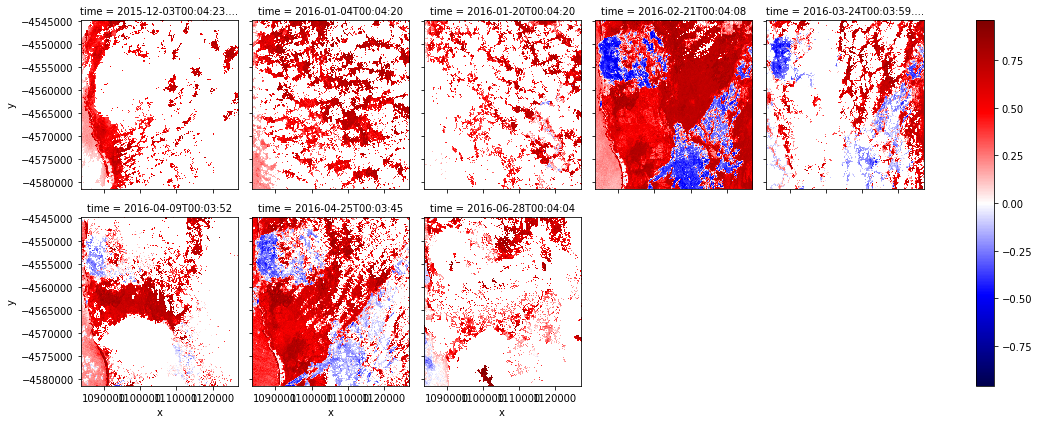

In [5]:
NBR = (data.nir-data.swir2)/(data.nir+data.swir2)
# plot NBR for the seleted period
NBR.sel(time=slice('2015-12-01','2016-12-01')).plot.imshow(col='time',col_wrap = 5,cmap='seismic')

## calculation of geometric median and cosine distance
import the module for the calculation of geometric median, cosine distance and euclidean distance from the burnmappingtoolbox package

geometric_median: to calculate the geometric median for the given period and region

$\hat{\mu}: = argmin\sum_{i=1}^{n}\parallel x-x_i\parallel$, $x\in \mathbb{R}^p$


cosdistance: to calculate the cosine distance from the original landsat reflectance time series data to the geometric median  

$cosdist = 1-\frac{\sum_{i=1}^{n}x_iy_i}{\sqrt{\sum_{i=1}^{n}x_i^2}\sum_{i=1}^{n}y_i^2}$


nbr_eucdistance: to calculate the euclidean distance from the NBR time series to the NBRmed calculated from the geometric median

$NBRdist = \sqrt{\sum_{i=1}^{n}(NBR_i-NBRmed)^2}$

use help(module_name) for the help information for each module, 

e.g. help(geometric_median) will show the following information:

Help on function geometric_median in module burnmappingtoolbox:

geometric_median(X, tol, MaxInter)

    This is a script to calculate the Geomatric Median 
    The required variables are:
    "X" is a p x N matric, wehre p = number of bands and N = the number of dates in the period of interest
    "MaxNIter" is the maximum number of iteration
    "tol" is tolerance
    The procedure stop when EITHER error tolerance in solution 'tol' or the maximum number of iteration 'MaxNIter' is reached. 
    Returns a p-dimensional vector   'geoMedian'


In [6]:
from burnmappingtoolbox import geometric_median, cosdistance, nbr_eucdistance

Calculate the geometric median and distances step by step like shown in the following 

Or use the prepackaged modules (explained in Case Example 2 with simple workflow)

In [7]:
#calculate the Geomatric Median for the whole period and the cosine distance relative to the geomatric median
MaxInter = 60
tol      = 1.e-7
Nbands = 6
GeoMed= np.empty((Nbands,len(data.y),len(data.x))) # geometric medians
GeoMed.fill(np.nan)
cosdist = np.empty((len(data.time),len(data.y),len(data.x))) # cosine distance
cosdist.fill(np.nan)
NBRdist = np.empty((len(data.time),len(data.y),len(data.x))) # NBR euclidean distance
NBRdist.fill(np.nan)
Sign = np.zeros((len(data.time),len(data.y),len(data.x))) # NBR change direction
NBRmed = np.empty((len(data.y),len(data.x))) # NBR geometric median
NBRmed.fill(np.nan)
for y in range(0,len(data.y)):
    #construct a p x N matric X including the 
    X = np.empty((Nbands,len(data.time),len(data.x)))
    X[0,:,:] = data.blue[:,y,:] 
    X[1,:,:] = data.green[:,y,:]
    X[2,:,:] = data.red[:,y,:]
    X[3,:,:] = data.nir[:,y,:]
    X[4,:,:] = data.swir1[:,y,:]
    X[5,:,:] = data.swir2[:,y,:]
    X[X<=0] = np.nan
    #calculation of geometric median for each row
    GeoMed[:,y,:] = np.transpose(np.vstack([geometric_median(X[:,:,x],tol,MaxInter) for x in range(0,len(data.x))]))
    
    #calculation of cosine distance for each row
    cosdist[:,y,:] = np.transpose(np.vstack([cosdistance(GeoMed[:,y,x],X[:,:,x]) for x in range(0,len(data.x))]))

    #calculation of NBR distance for each row
    NBRmed[y,:] = (GeoMed[3,y,:]-GeoMed[5,y,:])/(GeoMed[3,y,:]+GeoMed[5,y,:])    
    tmp = np.vstack([nbr_eucdistance(NBRmed[y,x],NBR.data[:,y,x]) for x in range(0,len(data.x))])
    NBRdist[:,y,:]=np.transpose((tmp[0:len(data.x)*2:2]))
    Sign[:,y,:]=np.transpose((tmp[1:len(data.x)*2:2]))

In [8]:
# calculate the outliers for change detection as (75th percentile + 1.5*IQR)
NBRoutlier=np.nanpercentile(NBRdist,75,axis=0)+1.5*(np.nanpercentile(NBRdist,75,axis=0)-np.nanpercentile(NBRdist,25,axis=0))
CDistoutlier=np.nanpercentile(cosdist,75,axis=0)+1.5*(np.nanpercentile(cosdist,75,axis=0)-np.nanpercentile(cosdist,25,axis=0))

The outputs above only need to generated once for the given region and period.

The outputs can be save as follow for other calculations.

In [9]:
ds = xr.Dataset({'GeoMed':(('bands','y','x'),GeoMed[:]),'CosDist':(('time','y','x'),cosdist[:]),
                'NBRDist':(('time','y','x'),NBRdist[:]),'NegtiveChange':(('time','y','x'),Sign[:]),
                'NBRoutlier':(('y','x'),NBRoutlier[:]),'CDistoutlier':(('y','x'),CDistoutlier)},
               coords={'time':data.time[:],'y':data.y[:],'x':data.x[:],'bands':np.linspace(0,5,6)},attrs={'crs':'EPSG:3577'})
ds.to_netcdf('Sumac_Forest_TAS_Landsat8_100m_2013-2017_GMandDist.nc')

plot the geometric median in RGB

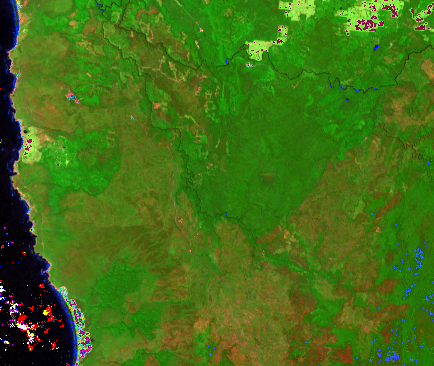

In [10]:
def stretch_RGB(data):
    """
    stretch RGB to 0-1
    """
    tmp = data
    a = (tmp-np.nanpercentile(tmp,1))/(np.nanpercentile(tmp,99.5)-np.nanpercentile(tmp,0.5))*255  
    return a
from PIL import Image,ImageEnhance

#plot the geometric median with swir2,nir and green band as R,G,B
rgbArray = np.zeros((len(data.y),len(data.x),3), 'uint8')
rgbArray[..., 0] = (stretch_RGB(GeoMed[5,:,:]))
rgbArray[..., 1] = (stretch_RGB(GeoMed[3,:,:]))
rgbArray[..., 2] = (stretch_RGB(GeoMed[1,:,:]))
img = Image.fromarray(rgbArray)
img

## fire/change detection and severity mapping
load severity mapping module from the burnmappingtoolbox

Three criterias are available to choose in the severity mapping, the default one is Method3. Data and time can be modified to run for the whole period or annual basis.

Method 1: only use cosine distance as an indicator for change

Method 2: use cosine distance together with NBR<0

Method 3: use both cosine distance, NBR euclidean distance, and NBR change direction for change detection

The following example shows the severity map for 2015.07 to 2016.06 using method 2 for fire-related sever NBR decrease mapping


In [11]:
from burnmappingtoolbox import severity

In [13]:
sevindex = np.zeros((len(data.y),len(data.x)))
duration = np.zeros((len(data.y),len(data.x)))
startdate = np.zeros((len(data.y),len(data.x)))
timeind = np.where((data.time<=np.datetime64('2016-06-30'))&(data.time>=np.datetime64('2015-07-01')))[0]
for x in range(0,len(data.x)):
    for y in range(0,len(data.y)):
        sevindex[y,x], startdate[y,x], duration[y,x]=severity(CDist=cosdist[timeind,y,x],CDistoutlier=CDistoutlier[y,x],Time=data.time[timeind],
             NBR=NBR[timeind,y,x],NBRDist=NBRdist[timeind,y,x],NBRoutlier=NBRoutlier[y,x], Sign=Sign[timeind,y,x], Method=2)

In [14]:
import pandas as pd
startdate[startdate==0]=np.nan
row,col = np.where(~np.isnan(startdate))
tmpdate = startdate.ravel()
Start_Date = startdate[row,col].astype('<M8[ns]')
Easting = data.x[col]
Northing = data.y[row]
Severity = sevindex[row,col]
Duration = duration[row,col]
firedataset=pd.DataFrame({'Easting':Easting,'Northing':Northing,'Start-Date':Start_Date,'Severity':Severity,'Duration':Duration})
firedataset

,Duration,Easting,Northing,Severity,Start-Date
0,31.999902,1086250.0,-4544950.0,0.222831,2016-02-21 00:04:08
1,63.999734,1086350.0,-4544950.0,1.665085,2016-02-21 00:04:08
2,63.999734,1086450.0,-4544950.0,1.521045,2016-02-21 00:04:08
3,63.999734,1086350.0,-4545050.0,1.240693,2016-02-21 00:04:08
4,31.999902,1086150.0,-4545150.0,0.191335,2016-02-21 00:04:08
5,127.999954,1086350.0,-4545150.0,6.769959,2016-02-21 00:04:08
6,63.999734,1086250.0,-4545250.0,1.739367,2016-02-21 00:04:08
7,127.999954,1086350.0,-4545250.0,4.137102,2016-02-21 00:04:08
8,63.999734,1098750.0,-4546250.0,1.024671,2016-02-21 00:04:08
9,63.999734,1098550.0,-4546350.0,1.589634,2016-02-21 00:04:08


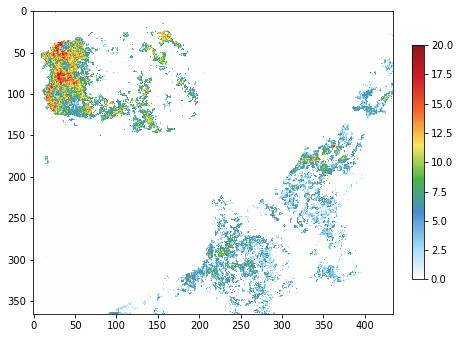

In [15]:
colors = pd.read_fwf('mycolormap.txt',header=None)
import matplotlib as mpl
import matplotlib.pyplot as plt
mycolormap = np.zeros((len(colors),3))
mycolormap[:,0]=colors[0]
mycolormap[:,1]=colors[1]
mycolormap[:,2]=colors[2]
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
          mycolormap/256)
plt.figure(figsize=(7,7))
im=plt.imshow(sevindex,cmap=cmap,vmax=20)
plt.colorbar(im,fraction=0.03, pad=0.05)
